In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd

# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
from sequence_logo import *
mwc.set_plotting_style()

colors_qual=sns.color_palette(
    ['#bf0087', '#e5b600', '#40ac00', '#5233ea', '#bf3800', '#00acac']) # Colors for non-sequential data
sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Figure 5

Here we use energy matrices and sequence logos to analyze the effects of amino acid mutations on sequence specificity. 

In [2]:
# Load mutant energy matrices and multipliers
mut_list = ['Y20I', 'Q21A', 'Q21M']
matrix_dict = {}
for mut in mut_list:
    matrix_file = glob.glob('../../data/models/' + mut + '_operator_MCMC_' + '*' + '_fixed')
    matrix_temp = np.loadtxt(matrix_file[0], skiprows=1)[:, 1:]
    mult_temp = np.mean(np.loadtxt('../../data/models/' + 'features_for_all_runs_' + mut,\
                                    skiprows=1)[:, 1:], axis=1)[1]
    matrix_dict[mut] = mult_temp * matrix_temp
    
# Load wt multipliers
mults = pd.read_csv('../../data/models/multipliers_revised', index_col=0)

# Load wt matrix and add to dict
RBS_name = '1027'
op = 'O1'
multiplier = mults['multiplier'][(mults['operator']==op) & (mults['RBS']==RBS_name)].values[0]
matrix_dict['wt'] = multiplier * np.loadtxt('../../data/models/%s%s_fixed_linear_all' % (op, RBS_name), skiprows=1)

## Sequence logos

Energy matrices can provide useful quantitative information, but sequence logos are a quantitative tool that provide a far more satisfying qualitative interpretation of the data. It would be worthwhile to find a scaling factor for the mutant energy matrices that allows us to do this. While this can be done by thermodynamic fitting, we can obtain a rough scaling factor by comparing with the scaled wt matrix. The relative binding strengths of the first six bases are roughly the same in each of the above matrices, so we may be able to use these to obtain a rough scaling factor.

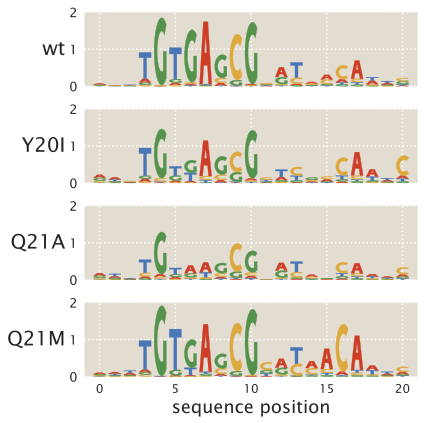

In [3]:
div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 6))

mut_list = ['wt', 'Y20I', 'Q21A', 'Q21M']

for i, a in enumerate(ax):
    seq_logo(matrix_dict[mut_list[i]], ax=a, colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    a.set_ylabel(mut_list[i], rotation = 0, ha = 'right', va = 'center', fontsize=20)
    a.set_xlim(0,22)
    a.set_ylim(0,2)
    a.set_xticks([1, 6, 11, 16, 21])
    a.set_xticklabels(['', '', '', '', ''])

ax[3].set_xlabel('sequence position')    
ax[3].set_xticklabels(['0', '5', '10', '15', '20'])
plt.tight_layout()

Now we will create a figure comparing both energy matrices and sequence logos. To quantify the differences between energy matrices we will calculate the Pearson's correlation coefficient between each energy matrix and the wild-type energy matrix. 

In [4]:
# Write function for finding pearson's correlation coefficient

def pearsons(X, Y):
    cov = 0
    for i in range(len(X)):
        cov += (X[i] - np.mean(X)) * (Y[i] - np.mean(Y))/len(X)
    return cov/(np.std(X) * np.std(Y))

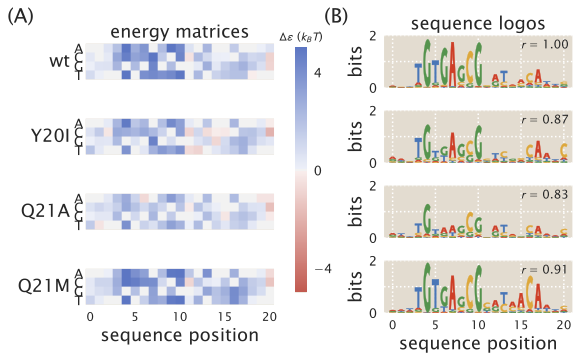

In [8]:
# Establish palette and list of matrices
div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
mut_list = ['wt', 'Y20I', 'Q21A', 'Q21M']

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 5))

# Plot energy matrices for each mutant

for i, row in enumerate(ax):
    im = row[0].imshow(matrix_dict[mut_list[i]].T, cmap=div_colors, clim=[-5, 5])
    row[0].yaxis.set_ticks([0, 1, 2, 3])
    row[0].set_yticklabels(['A', 'C', 'G', 'T'], ha='center')
    row[0].set_xticklabels(['', '', '', '', ''])
    row[0].set_ylabel(mut_list[i], rotation=0, va='center', ha='right')
    row[0].grid(False)
    
# Plot sequence logos for each mutant
    
    seq_logo(matrix_dict[mut_list[i]], ax=row[1], colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    row[1].set_xlim(0, 22)
    row[1].set_ylim(0, 2)
    row[1].set_yticks([0, 1, 2])
    row[1].set_ylabel('bits')
    row[1].set_yticklabels(['0', '', '2'])
    row[1].set_xticks([1, 6, 11, 16, 21])
    row[1].set_xticklabels(['', '', '', '', ''])
    row[1].text(16, 1.5, r'$r$ = %0.2f'\
                % pearsons(matrix_dict[mut_list[0]].ravel(), matrix_dict[mut_list[i]].ravel()),
               ha='left', fontsize=12)


# Set figure labels
ax[3][0].set_xticklabels(['0', '0', '5', '10', '15', '20'])
ax[3][0].set_xlabel('sequence position')
ax[3][1].set_xticklabels(['0', '5', '10', '15', '20'])
ax[3][1].set_xlabel('sequence position')

ax[0][0].set_title('energy matrices', fontsize=18)
ax[0][1].set_title('sequence logos', fontsize=18)

plt.tight_layout(w_pad=7)
plt.figtext(0.51, 0.9, r'$\Delta \varepsilon$ ($k_BT$)', ha='center', fontsize=12)
plt.figtext(0, 0.95, '(A)', fontsize=20)
plt.figtext(0.55, 0.95, '(B)', fontsize=20)

cb_ax = fig.add_axes([0.5, 0.2, 0.02, 0.68])
cb = fig.colorbar(im, cb_ax)
cb.set_ticks([-4, 0, 4])

#plt.savefig('energy_matrices.pdf', bbox_inches='tight')